[Reference](https://towardsdatascience.com/goodbye-scatterplot-welcome-binned-scatterplot-a928f67413e4)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'gray'
mpl.rcParams['legend.borderpad'] = 0.6

# Lines
mpl.rcParams['lines.linewidth'] = 3

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
"""
Title:  Data Generating Processes
Author: Matteo Courthoud
Date:   24/03/2022
"""


import numpy as np
import scipy as sp
import pandas as pd

from numpy.random import normal as rnd
from scipy.special import expit
from sklearn.preprocessing import MinMaxScaler

class dgp_ad():
    """
    Data Generating Process: ads
    """
    
    def __init__(self):
        self.Y = 'revenue'
        self.T = 'ad_exposure'
        self.X = ['male', 'black', 'age', 'educ']
    
    def generate_data(self, seed=1, N=1000, oracle=False):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame({'male': np.random.binomial(1, 0.5, N),
                           'black': np.random.binomial(1, 0.5, N),
                           'age': np.rint(np.random.normal(45, 10, N))})

        # Endogenous observables
        df['educ'] = np.random.poisson(2*df['black'] + 1)

        # Treatment
        df[self.T] = (np.random.uniform(0, 2, N) \
                    + 0.3 * df['male'] \
                    - 0.2 * df['black']) > 1

        # Treatment effect
        Y0 =  0.5 * df['male'] \
            - 0.5 * df['black'] \
            + 0.1 * np.log(1 + df['educ']) \
            - 0.2 * (df['age']>50) \
            + rnd(0, 1, N)
        Y1 = Y0 \
            + 0.5 \
            + 0.4 * df['male'] \
            + 0.1 * np.log(1 + df['educ']) \
            + 0.2 * (df['age']>40)
        if oracle:
            df['Y0'] = Y0
            df['Y1'] = Y1
        df[self.Y] = Y0 + Y1 * df[self.T]
       
        return df


class dgp_aipw():
    """
    Data Generating Process for AIPW
    
    from https://www.youtube.com/watch?v=IfZHUFFlsGc
    """
    
    def __init__(self, p=20):
        self.p = p
        self.Y = 'Y'
        self.T = 'T'
        self.X = [f"x{i}" for i in range(1,p+1)]
    
    def generate_data(self, seed=1, N=1000):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame(np.random.normal(0, 1, (N, self.p)), columns=self.X)

        # Propensity score
        df['e'] = 1 / (1 + np.exp(- df['x1']))

        # Treatment
        df['T'] = (np.random.uniform(0, 1, N) < df['e']).astype(int)

        # Outcomes
        df['Y0'] = np.maximum(df['x1'] + df['x2'], 0) - 0.05 * df['T']
        df['Y1'] = np.maximum(df['x1'] + df['x3'], 0) - 0.05 * df['T'] - 0.05
        df['Y'] = df['Y0'] * (1-df['T']) + df['Y1'] * df['T']

        return df


class dgp3():
    """
    Data Generating Process 3
    """
    
    def __init__(self, p=20):
        self.p = p
        self.Y = 'Y'
        self.T = 'T'
        self.X = [f"x{i}" for i in range(1,p+1)]
    
    def generate_data(self, seed=1, N=1000):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame(np.random.normal(0, 1, (N, self.p)), columns=self.X)

        # Propensity score
        df['e'] = 1 / (1 + np.exp(- df['x1']))

        # Treatment
        df['T'] = (np.random.uniform(0, 1, N) < df['e']).astype(int)

        # Outcomes
        df['Y'] = np.maximum(df['x1'] + df['x2'] * (1-df['T']) + df['x3'] * df['T'], 0) - 0.05 * df['T']

        return df


class dgp4():
    """
    Data Generating Process 4
    
    from https://www.youtube.com/watch?v=N9ThAs7NS0g
    """
    
    def __init__(self, p=10):
        self.p = p
        self.Y = 'Y'
        self.T = 'T'
        self.X = [f"x{i}" for i in range(1,p+1)]
    
    def generate_data(self, seed=1, N=4000):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame(np.random.normal(0, 1, (N, self.p)), columns=self.X)

        # Treatment probability
        df['e'] = 0.3

        # Treatment assignment
        df['T'] = (np.random.uniform(0, 1, N) < df['e']).astype(int)
        
        # Treatment effect
        df['tau'] = 1 / (1 + np.exp(-df['x3']))

        # Outcomes
        df['Y'] = np.maximum(df['x1'] + df['x2'], 0) + df['T'] * df['tau'] + np.random.normal(0, 1, N)

        return df  


class dgp_newsletter():
    """
    Data Generating Process: reminder to sign up to newsletter
    """
    
    def __init__(self):
        self.Z = 'reminder'
        self.T = 'subscribe'
        self.Y = 'revenue'
        self.X = []
    
    def generate_data(self, seed=1, N=1000, oracle=False):
        np.random.seed(seed)
        
        # Nudge / instrument
        df = pd.DataFrame({self.Z: np.random.binomial(1, 0.5, N)})
        
        # Hidden type
        income = np.random.exponential(1, N)
        if oracle: df['income'] = income
            
        # Treatment assignment
        df[self.T] = (expit(- income + df[self.Z] + rnd(size=N)) > 0.5).astype(int)
        
        # Treatment effect
        tau = 1
        if oracle: df['tau'] = tau

        # Outcome
        df[self.Y] = -1 + 2*income + tau*df[self.T] + rnd(size=N)

        return df



class dgp_membership():
    """
    Data Generating Process: Incentives for membership
    
    inspired by: https://github.com/microsoft/EconML/blob/main/notebooks/CustomerScenarios
    """
    
    def __init__(self):
        self.Z = 'easier_signup'
        self.T = 'became_member'
        self.Y = 'revenue_post'
        self.X = []
    
    def generate_data(self, seed=1, N=100000, oracle=False):
        np.random.seed(seed)

        # Exogenous observables
        df = pd.DataFrame({'visit_flights': np.random.randint(0, 28, N),
                           'visit_hotels': np.random.randint(0, 28, N),
                           'visit_restaurants': np.random.randint(0, 28, N),
                           'visit_rental': np.random.randint(0, 28, N),
                           'origin_US': np.random.binomial(1, 0.7, N),
                           'mobile': np.random.binomial(1, 0.3, N),
                           'revenue_pre': np.random.exponential(1, N)})
        self.X = df.columns
        
        # Hidden type
        income = np.random.exponential(1, N)

        # Nudge / instrument
        df[self.Z] = np.random.binomial(1, 0.5, N)

        # Treatment probability
        e = expit(- income + df[self.Z] + rnd(size=N))
        if oracle: df['e'] = e
        
        # Treatment assignment
        df[self.T] = (np.random.uniform(0, 1, N) < e).astype(int)
        
        # Treatment effect
        tau = 0.2 + 0.3 * df['visit_flights'] - 0.2*df['visit_rental'] + df['mobile']
        if oracle: df['tau'] = tau

        # Outcome
        df[self.Y] = 1 + df['revenue_pre'] + 2*income + tau*df[self.T] + rnd(size=N)

        return df.round(2)
    

class dgp_ao18():
    """
    Data Generating Process: Anna and Olken (2018)
    
    inspired by: https://github.com/microsoft/EconML/blob/main/notebooks/CustomerScenarios
    """
    
    def __init__(self):
        self.T = 'cash_transfer'
        self.Y = 'welfare'

    def import_data(self, seed=1, oracle=False):
        np.random.seed(seed)

        # Import data
        df = pd.read_csv('data/ao18.csv')
        
        self.X = [c for c in df.columns if c not in ['hhid', 'consumption_0']]

        # Treatment 
        df['cash_transfer'] = np.random.binomial(1, 0.5, len(df))

        # Treatment effect
        df['consumption'] = df['consumption_0'] + df['cash_transfer']*100

        # Hide 
        df['welfare'] = np.log(df['consumption'])

        # Hide variables
        if oracle:
            df['welfare_0'] = np.log(df['consumption_0'])
            df['welfare_1'] = np.log(df['consumption_0'] + 100)
        else:
            df = df.drop(columns=['consumption_0'])

        # Return
        return df.dropna()
    

class dgp_did():
    """
    Data Generating Process: TV advertising
    
    Inspired by: https://matheusfacure.github.io/python-causality-handbook/13-Difference-in-Differences.html
    """
    
    def __init__(self):
        self.D = 'treated'
        self.Y = 'revenue'
        self.T = 'days'

    def generate_data(self, seed=1, N=100, T=20, oracle=False):
        np.random.seed(seed)

        # Init data
        df = pd.DataFrame(np.array(np.meshgrid(range(1, T+1), range(1,N), [0,1])).T.reshape(-1,3), 
                  columns=['day', 'id', 'treated'])
        #df['treated'] = df['treated'].astype('bool')
        
        
        # Treatment
        alpha_i = np.sqrt(df['id']) - 3*(df['id']>10)
        gamma_t = 0.1*df['day'] + rnd(size=len(df))
        tau_it = 0.5*np.log(1+df['id']) - 0.12*df['day']
        
        # Effect
        df['post'] = (df['day'] > T/2)
        df['revenue'] = alpha_i + gamma_t + \
                        1.2*df['treated'] + \
                        df['post']*df['treated']*tau_it + \
                        rnd(size=len(df))
        
        # Hide variables
        if oracle:
            df['alpha_i'] = alpha_i
            df['gamma_t'] = gamma_t
            df['tau_it'] = tau_it

        # Return
        return df
    
    
class dgp_school():
    """
    Data Generating Process: class size and test scores
    """
    
    def __init__(self):
        self.T = 'class_size'
        self.Y = 'math_score'
    
    def generate_data(self, seed=1, N=1000, oracle=False):
        np.random.seed(seed)
        
        # Dataframe
        df = pd.DataFrame({'math_hours': np.random.randint(2,5,N),
                           'history_hours': np.random.randint(2,5,N),
                           'good_school': np.random.binomial(1,0.5,N),
                           'class_year': np.random.randint(1,5,N)})
        
        # Treatment
        df[self.T] = np.random.poisson(25, N) - 1*df['class_year'] - 7*df['good_school']
        
        # Hidden ability
        ability = np.random.exponential(1, N)
        history_hours = np.random.randint(3,5,N)
            
        # Main outcome
        df[self.Y] = 1 + 0.2*df[self.T] + ability + df['math_hours'] + 5*df['good_school'] + rnd(size=N)
        
        # Other outcome
        df['hist_score'] = 1 + 0.2*df[self.T] + ability + history_hours + 5*df['good_school'] + rnd(size=N)
                
        return df
    

class dgp_marketplace():
    """
    Data Generating Process: online marketplace
    """
    
    def generate_data(self, seed=1, N=10_000):
        np.random.seed(seed)
        
        # Does the firm sells only online?
        online = np.random.binomial(1, 0.5, N)
        
        # How many products does the firm have
        products = 1 + np.random.poisson(1, N)
        
        # What is the age of the firm
        t = np.random.exponential(0.5*products, N) 
        
        # Sales
        sales = 1e3 * np.random.exponential(products + np.maximum((1 + 0.3*products + 4*online)*t - 0.5*(1 + 6*online)*t**2, 0), N)

        # Generate the dataframe
        df = pd.DataFrame({'age': t, 'sales': sales, 'online': online, 'products': products})
                
        return df

In [4]:
df = dgp_marketplace().generate_data(N=10_000)
df.head()

,age,sales,online,products
0,0.312777,450.858091,0,2
1,1.176221,1121.882449,1,3
2,1.764048,2698.714549,0,1
3,1.082742,1627.746386,0,3
4,3.156503,1464.593939,0,2


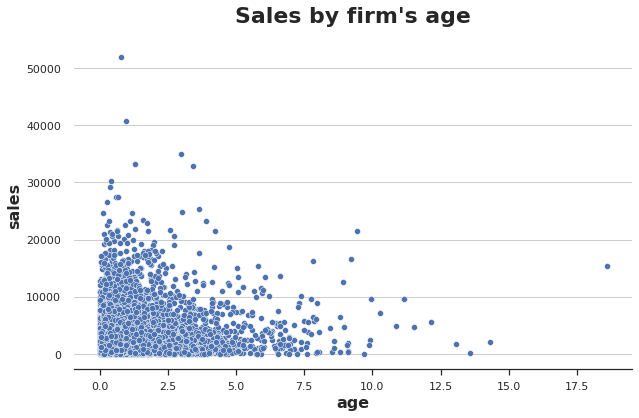

In [6]:
sns.scatterplot(x='age', y='sales', data=df);
plt.title("Sales by firm's age");

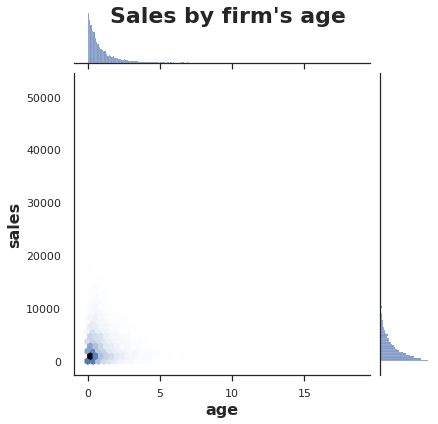

In [7]:
s = sns.jointplot(x='age', y='sales', data=df, kind='hex', );
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age");

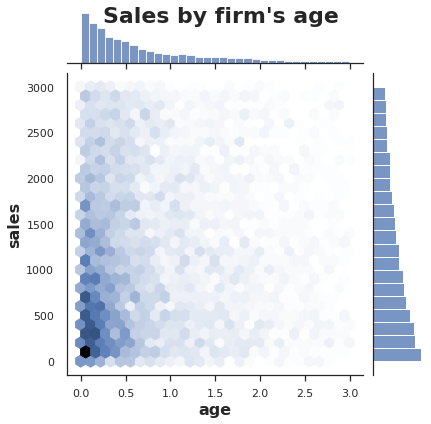

In [8]:
s = sns.jointplot(x='age', y='sales', data=df.query("age < 3 & sales < 3000"), kind="hex");
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age");

In [9]:
df['log_age'] = np.log(df['age'])
df['log_sales'] = np.log(df['sales'])

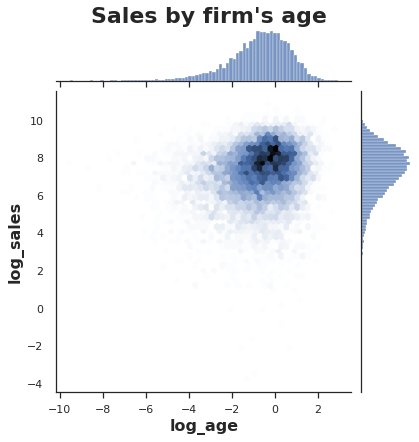

In [10]:
s = sns.jointplot(x='log_age', y='log_sales', data=df, kind='hex');
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age", y=1.02);

In [11]:
smf.ols('log_sales ~ log_age', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.3971,0.015,478.948,0.000,7.367,7.427
log_age,0.1690,0.010,16.888,0.000,0.149,0.189


In [12]:
smf.ols('log_sales ~ log_age + online + products', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.5717,0.037,176.893,0.000,6.499,6.644
log_age,0.0807,0.010,7.782,0.000,0.060,0.101
online,0.1447,0.027,5.433,0.000,0.092,0.197
products,0.3456,0.014,24.110,0.000,0.317,0.374


# The Binned Scatterplot

In [14]:
pip install binsreg

     |████████████████████████████████| 69 kB 3.7 MB/s 


In [15]:
import binsreg

def binscatter(**kwargs):
    # Estimate binsreg
    est = binsreg.binsreg(**kwargs)
    
    # Retrieve estimates
    df_est = pd.concat([d.dots for d in est.data_plot])
    df_est = df_est.rename(columns={'x': kwargs.get("x"), 'fit': kwargs.get("y")})
    
    # Add confidence intervals
    if "ci" in kwargs:
        df_est = pd.merge(df_est, pd.concat([d.ci for d in est.data_plot]))
        df_est = df_est.drop(columns=['x'])
        df_est['ci'] = df_est['ci_r'] - df_est['ci_l']
    
    # Rename groups
    if "by" in kwargs:
        df_est['group'] = df_est['group'].astype(df[kwargs.get("by")].dtype)
        df_est = df_est.rename(columns={'group': kwargs.get("by")})

    return df_est

In [16]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', data=df, ci=(3,3))
df_est.head()

,group,age,bin,isknot,mid,sales,ci_l,ci_r,ci
0,Full Sample,0.012556,0,0,0,1624.779616,1312.439124,1905.535412,593.096288
1,Full Sample,0.037015,1,0,0,1664.078013,1435.438411,1893.888819,458.450408
2,Full Sample,0.065813,2,0,0,1779.657894,1555.909281,1968.681960,412.772679
3,Full Sample,0.094486,3,0,0,1976.464837,1740.530049,2216.800005,476.269956
4,Full Sample,0.125363,4,0,0,2015.833752,1796.489393,2280.237320,483.747927


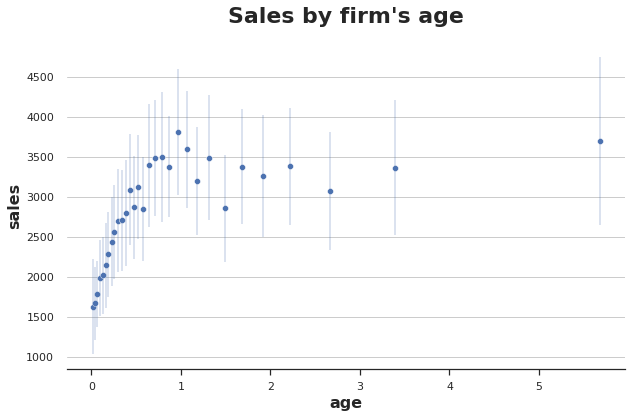

In [17]:
# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est);
plt.errorbar('age', 'sales', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

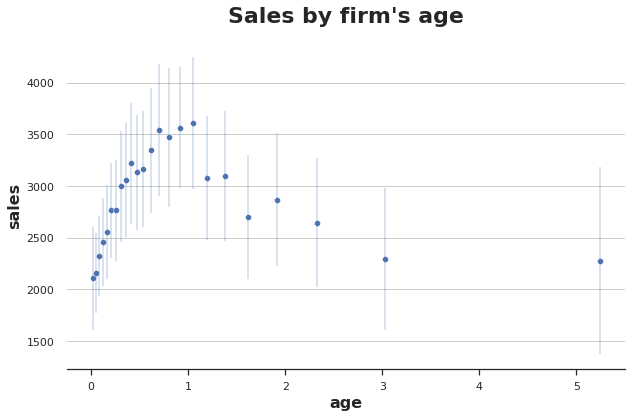

In [18]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', w=['products'], data=df, ci=(3,3))

# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est);
plt.errorbar('age', 'sales', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

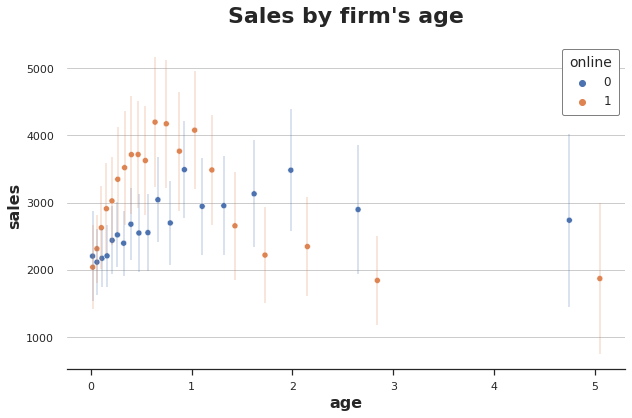

In [19]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', by='online', w=['products'], data=df, ci=(3,3))

# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est, hue='online');
plt.errorbar('age', 'sales', yerr='ci', data=df_est.query("online==0"), ls='', lw=2, alpha=0.2);
plt.errorbar('age', 'sales', yerr='ci', data=df_est.query("online==1"), ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");